# Embedding in traditional features

In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
import os
import pandas as pd
import sys
import numpy as np
import statistics
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.legend import Legend
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc, gridspec
import matplotlib
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import umap
from scipy.stats import zscore
from sklearn import metrics
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.legend import Legend
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc, gridspec
import matplotlib
import seaborn as sns
from matplotlib.text import Annotation
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
import scipy
from scipy.spatial.distance import euclidean as euclid
from scipy.spatial import distance_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import datetime


PROJECT_PATH = "/content/drive/My Drive/meerkat/" 
FIGURES = PROJECT_PATH+"figures/"
DATA = PROJECT_PATH+"data/"

os.chdir(PROJECT_PATH)

In [3]:
# Function that pads a spectrogram with zeros to a certain length
# Input: spectrogram (2D np array)
#        maximal length (Integer)
# Output: Padded spectrogram (2D np array)

def pad_spectro(spec,maxlen):
  padding = maxlen - spec.shape[1]
  z = np.zeros((spec.shape[0],padding))
  padded_spec=np.append(spec, z, axis=1)
  return padded_spec

def make_nn_stats_dict(calltypes, labels, indices):
  nn_stats_dict = {}

  for calltype in calltypes:
    call_indices = np.asarray(np.where(labels==calltype))[0]
    calltype_counts = np.zeros((call_indices.shape[0],len(calltypes)))

    for i,ind in enumerate(call_indices):
      nearest_neighbors = indices[ind]
      for neighbor in nearest_neighbors:
        neighbor_label = labels[neighbor]
        calltype_counts[i,np.where(np.asarray(calltypes)==neighbor_label)[0][0]] += 1 
    nn_stats_dict[calltype] = calltype_counts 
  
  return nn_stats_dict

def get_knn(k,embedding):

  # Scale
  scaler = MinMaxScaler(feature_range=(0,10))
  scaler.fit(embedding)
  embedding = scaler.transform(embedding)
  metric_type = 'euclidean'

  # Find k nearest neighbors
  nbrs = NearestNeighbors(metric='euclidean',n_neighbors=k+1, algorithm='brute').fit(embedding)
  distances, indices = nbrs.kneighbors(embedding)

  # need to remove the first neighbor, because that is the datapoint itself
  indices = indices[:,1:]  
  distances = distances[:,1:]

  return indices, distances


def make_statstabs(nn_stats_dict, calltypes, labels):
  # Overall frequencies
  overall = np.zeros((len(calltypes)))
  for i,calltype in enumerate(calltypes):
    overall[i] = sum(labels==calltype)

  overall = (overall/np.sum(overall))*100


  stats_tab = np.zeros((len(calltypes),len(calltypes)))
  stats_tab_norm = np.zeros((len(calltypes),len(calltypes)))

  for i, calltype in enumerate(calltypes):
    stats = nn_stats_dict[calltype]
    stats_tab[i,:] = (np.mean(stats,axis=0)/k)*100
    stats_tab_norm[i,:] = ((np.mean(stats,axis=0)/k)*100)/overall

  stats_tab = pd.DataFrame(stats_tab)
  stats_tab_norm = pd.DataFrame(stats_tab_norm)

  stats_tab.loc[len(stats_tab)] = overall
  #stats_tab_norm.loc[len(stats_tab_norm)] = overall/overall

  stats_tab.columns = calltypes
  stats_tab.index = calltypes+['overall']

  stats_tab_norm.columns = calltypes
  stats_tab_norm.index = calltypes

  x=stats_tab_norm.replace(0, 0.0001)
  stats_tab_norm = np.log2(x)

  #stats_tab_norm = np.log2(stats_tab_norm)

  return stats_tab, stats_tab_norm

# Load datasets

In [4]:
df = pd.read_pickle(DATA+'df_denoised_balanced')
df = df[df.nonfocal_yn == 'n'] # for focal
df.reset_index(inplace=True)
df.head(3)

index   Name        Start  ... certain_yn index_id nonfocal_yn
0   1598  ALARM  1:10:56.215  ...          y     1598           n
1   1599  ALARM  1:12:04.643  ...          y     1599           n
2   1600  ALARM  1:12:15.132  ...          y     1600           n

[3 rows x 36 columns]

In [5]:
features = pd.read_csv(PROJECT_PATH+"data/frants/mara_features_allSNR_2.csv")
features.head(20)

CALL_INDEX Call_Type  Energy_Duration  ...       F0_mid       F0_end        SNR
0            0        sn         0.034750  ...  1296.875000  1273.437500   8.456472
1        10000        al         0.099750  ...   546.006944   621.961806  39.723752
2        10001        al         0.083625  ...   572.265625   603.732639  37.009269
3        10002        al         0.082250  ...   632.378472   578.993056  35.593729
4        10003        al         0.082500  ...   535.590278   563.802083  25.857987
5        10004        al         0.080500  ...   608.072917   501.953125  15.716379
6        10008       soc         0.321000  ...   755.859375   789.062500  26.256420
7        10009       soc         0.307000  ...   644.531250   828.125000  25.337350
8        10010       soc         0.330625  ...   906.250000   742.187500  36.730286
9        10011       soc         0.336000  ...  1171.875000  1445.312500  29.375650
10       10012       soc         0.131750  ...  1242.187500  1414.062500  28.962744
11       10013       soc         0.383500  ...   617.187500   705.078125  25.930307
12       10015       soc         0.329000  ...   599.609375   652.343750  26.687569
13       10018        al         0.040500  ...   728.515625   678.819444  11.403113
14       10034       agg         0.088375  ...   476.562500   804.687500  22.233976
15       10035       agg         0.073250  ...   679.687500   554.687500  -1.729059
16       10036       agg         0.051250  ...   720.703125   617.187500   4.575198
17       10037       agg         0.067375  ...   664.062500   859.375000  10.316930
18       10038       agg         0.101375  ...   929.687500   656.250000  13.078906
19       10039       agg         0.301000  ...   376.953125   476.562500  23.510987

[20 rows x 17 columns]

Check for NA values

In [ ]:
features.isnull().sum()

CALL_INDEX                  0
Call_Type                   0
Energy_Duration             0
Spectral_Entropy            0
Temporal_Entropy            0
Cepstral_Peak_Prominence    0
Centroid_Frequency          0
Peak_Frequency              0
lower_frequency_10dB        0
Upper_Frequency_10dB        0
Bandwidth_RMS               0
Bandwidth_10dB              0
F0_mean                     0
F0_start                    0
F0_mid                      0
F0_end                      0
SNR                         0
dtype: int64

There may have been a mixup. Check an example.

In [ ]:
e = 1641
e = 24005

In [ ]:
features.loc[features.CALL_INDEX==e,:]

CALL_INDEX Call_Type  Energy_Duration  ...      F0_mid      F0_end        SNR
3144       24005        cc         0.115875  ...  494.140625  357.638889  15.451636

[1 rows x 17 columns]

In [ ]:
allfiles = os.listdir(DATA+'frants_padded/')

In [ ]:
print([s for s in allfiles if '1642' in s])

['padded_16421_soc.wav', 'padded_16422_soc.wav', 'padded_16423_soc.wav', 'padded_16426_soc.wav', 'padded_16427_soc.wav', 'padded_1642_agg.wav']


In [ ]:
df.loc[df['index_id']==e,:].call_lable.values[0]

'cc'

Add the (potentially) correct label:

In [ ]:
call_indices = list(features.CALL_INDEX)
features['true_label'] = [df.loc[df['index_id']==ind,:].call_lable.values[0] for ind in call_indices]

In [ ]:
features.loc[features.CALL_INDEX==1642,:]

CALL_INDEX Call_Type  Energy_Duration  ...      F0_end     SNR  true_label
1831        1642       agg         0.121875  ...  896.484375  9.2202         agg

[1 rows x 18 columns]

In [ ]:
equal = [True if x==y else False for x,y in zip(features['Call_Type'].tolist(), 
                                         features['true_label'].tolist())]

In [ ]:
pd.Series(equal).value_counts()

True    6668
dtype: int64

# Check if reasonable

Boxplot for different variables based on calltype

In [ ]:
truth = 'true_label'
truth = 'Call_Type'

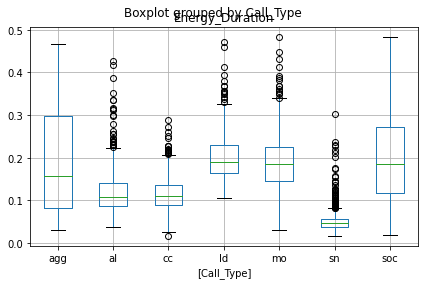

In [ ]:
boxplot = features[[truth, 'Energy_Duration']].boxplot(by=truth)
plt.tight_layout()

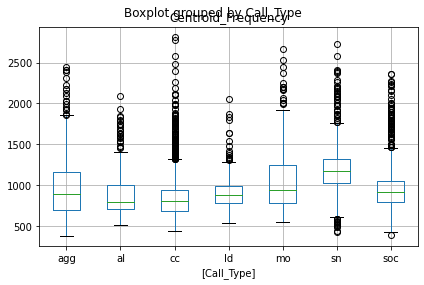

In [ ]:
boxplot = features[[truth, 'Centroid_Frequency']].boxplot(by=truth)
plt.tight_layout()

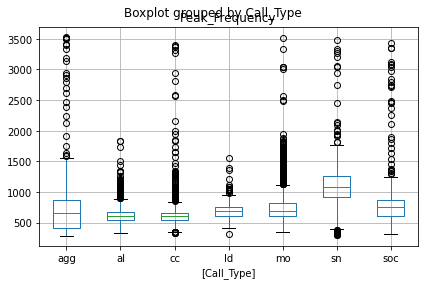

In [ ]:
boxplot = features[[truth, 'Peak_Frequency']].boxplot(by=truth)
plt.tight_layout()

# Dimensionality reduction with features

In [6]:
embedding_dict = {}

In [7]:
def plotly_viz(method):

  embedding = embedding_dict[method]
  x, y, z = embedding[:,0], embedding[:,1], embedding[:,2] 
  scat_labels = labels
  labeltypes = sorted(list(set(scat_labels)))

  # makes colors same as AVGN visualization
  pal = sns.color_palette("Set2", n_colors=len(labeltypes))
  color_dict = dict(zip(labeltypes, pal))
  c = [color_dict[val] for val in scat_labels]

  fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                    mode='markers',
                                    hovertext = labels,
                                    marker=dict(
                                        size=4,
                                        color=c,                # set color to an array/list of desired values
                                        opacity=0.8
                                        ))])

  fig.update_layout(scene = dict(
                      xaxis_title=method+'1',
                      yaxis_title=method+'2',
                      zaxis_title=method+'3'),
                      width=700,
                      margin=dict(r=20, b=10, l=10, t=10))

  return fig

#plotly_viz("UMAP").show()

In [8]:
def plt_3D(scat_labels, embedding, dim_type, input_type):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(111, projection='3d')

  labeltypes = sorted(list(set(scat_labels)))

  # makes colors same as AVGN visualization
  pal = sns.color_palette("Set2", n_colors=len(labeltypes))
  color_dict = dict(zip(labeltypes, pal))

  c = [color_dict[val] for val in scat_labels]

  Axes3D.scatter(ax,
                xs = embedding[:,0],
                ys = embedding[:,1],
                zs = embedding[:,2],
                zdir='z',
                s=10,
                label = c,
                c=c,
                depthshade=False)

  ax.set_xlabel(dim_type+'1')
  ax.set_ylabel(dim_type+'2')
  ax.set_zlabel(dim_type+'3')

  scatters = []
  for label in labeltypes:
    scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))

  ax.legend(scatters, labeltypes, numpoints = 1)

  #plt.show()
  plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+input_type+'_'+dim_type)

## Prepare input data

In [9]:
features['temp'] = features['F0_end']-features['F0_start']

choose columns to drop

In [12]:
columns_to_drop = ['CALL_INDEX', 'Call_Type', 'SNR', 'F0_start', 'F0_mid', 'F0_end']
columns_to_drop = ['CALL_INDEX', 'Call_Type', 'SNR']
truth = 'Call_Type'

Choose data

In [ ]:
# A) Full dataset
data = features.drop(columns=columns_to_drop)
labels = features.Call_Type
labels = features[truth]

In [13]:
# B) reduce set to only high quality (signal to noise > 10 dB)
data = features.loc[features.SNR>10,]
labels = data.Call_Type
labels = data[truth]
data = data.drop(columns=columns_to_drop)
data.shape

(5306, 15)

In [ ]:
data.head(3)

Energy_Duration  Spectral_Entropy  ...      F0_end        temp
1         0.099750          3.278152  ...  621.961806    0.434028
2         0.083625          4.258224  ...  603.732639  -75.954861
3         0.082250          5.518051  ...  578.993056 -165.147569

[3 rows x 15 columns]

z-transform

In [14]:
data_z = StandardScaler().fit_transform(data)

In [15]:
data = np.asarray(data)

## UMAP

In [16]:
#UMAP
reducer = umap.UMAP(low_memory=True, n_components = 5, min_dist=0, random_state=2204)
embedding_dict['UMAP-trad'] =  reducer.fit_transform(data_z)
labels = features.loc[features.SNR>10,]['Call_Type']
plotly_viz("UMAP-trad").show()

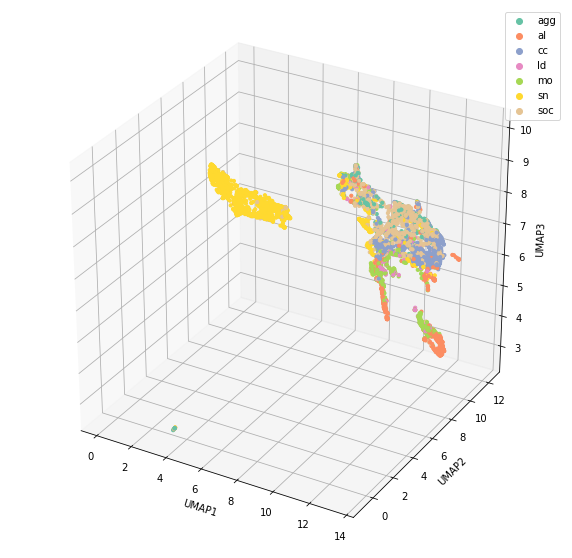

In [17]:
dim_type = 'UMAP'
input_type = 'trad'
plt_3D(labels, embedding_dict[dim_type+'-'+input_type], dim_type, input_type)

## tSNE

In [ ]:
model = TSNE(n_components=3, init='pca', random_state=0, perplexity=data.shape[0]/100, learning_rate=round(data.shape[0]/12))
embedding_dict['tSNE-trad'] = model.fit_transform(data_z) 
labels = features.loc[features.SNR>10,]['Call_Type']
plotly_viz('tSNE-trad').show()

## PCA

In [ ]:
dim_type = 'PCA'
input_type = 'trad'

p = PCA(n_components=10, random_state=728)
p.fit(np.transpose(data_z))
embedding_dict['PCA-trad'] = np.transpose(p.components_)
labels = features.loc[features.SNR>10,]['Call_Type']
plotly_viz("PCA-trad").show()

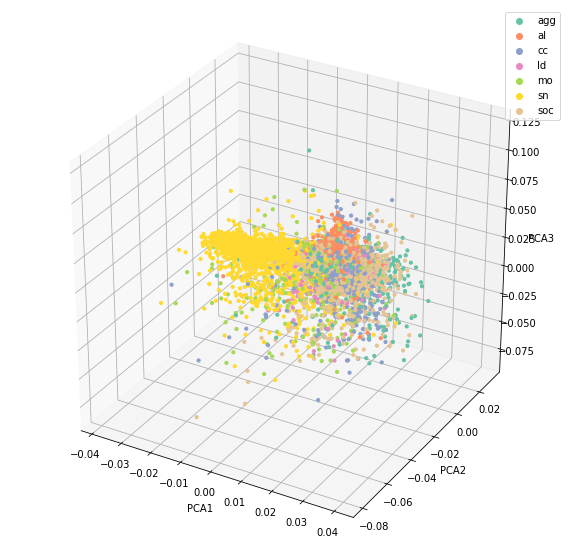

In [ ]:
dim_type = 'PCA'
input_type = 'trad'
plt_3D(labels, embedding_dict[dim_type+'-'+input_type], dim_type, input_type)

# Dimensionality reduction with spectrogram

## Prepare input data

Also filter the noisy ones.

In [18]:
clean_indices = features.loc[features['SNR']>10,:].CALL_INDEX

spec_df = df[df['index_id'].isin(list(clean_indices))]
labels = spec_df.call_lable

specs = spec_df.denoised_spectrograms.values # now 2D arrays n_mels+time_frames(varying)

def pad_spectro(spec,maxlen):
  padding = maxlen - spec.shape[1]
  z = np.zeros((spec.shape[0],padding))
  padded_spec=np.append(spec, z, axis=1)
  return padded_spec

maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
#flattened_specs = [pad_spectro(spec, maxlen).flatten(order='A') for spec in specs]
specs_arr = np.asarray(flattened_specs)
data = specs_arr

# Normalize
#data = StandardScaler().fit_transform(pd.DataFrame(data))

## UMAP

In [19]:
#UMAP
reducer = umap.UMAP(low_memory=True, n_components = 5, min_dist=0, random_state=2204)
embedding_dict['UMAP'] =  reducer.fit_transform(data)
labels = spec_df.call_lable
plotly_viz("UMAP").show()

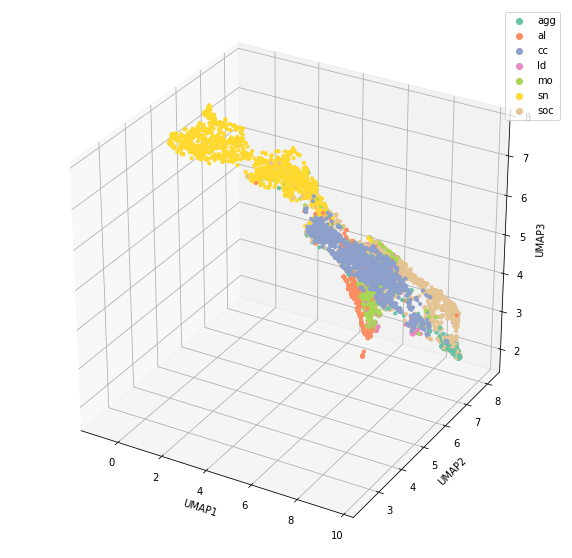

In [ ]:
dim_type = 'UMAP'
input_type = 'spectro'
plt_3D(labels, embedding_dict[dim_type], dim_type, input_type)

## tSNE

In [ ]:
model = TSNE(n_components=3, init='pca', random_state=0, perplexity=data.shape[0]/100, learning_rate=round(data.shape[0]/12))
embedding_dict['tSNE'] = model.fit_transform(data)
labels = spec_df.call_lable
plotly_viz('tSNE').show()

# Evaluate embedding

In [ ]:
embedding = embedding_dict['UMAP-trad']
labels = features.loc[features.SNR>10,]['Call_Type']


#embedding = embedding_dict['UMAP']
#labels = spec_df.call_lable
#embedding = data

In [ ]:
k=5

# Find k nearest neighbors
nbrs = NearestNeighbors(metric='euclidean',n_neighbors=k+1, algorithm='brute').fit(embedding)
distances, indices = nbrs.kneighbors(embedding)


for i in data.shape[0]:


In [ ]:
np.concatenate([nn_stats_dict['al'], nn_stats_dict['agg']], axis=0).shape

(827, 7)

In [ ]:
indices[10,:]

array([ 601,    5, 1803,  600, 4738])

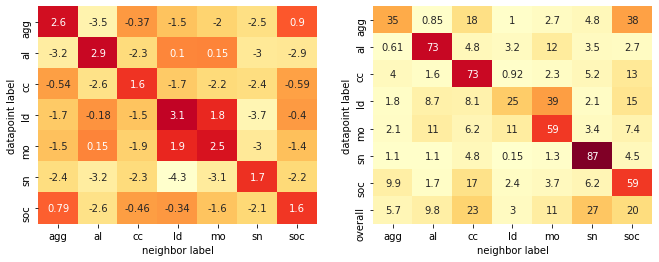

In [ ]:

plt.figure(figsize=(11,4))

plt.subplot(1, 2, 1)
ax=sns.heatmap(stats_tab_norm, center=0, annot=True, cmap='YlOrRd', cbar=None)
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
#plt.show()

# for easier interpretation: fold likelihood (x times more likely to find label in neighborhood
# than expected by chance)
#plt.subplot(1, 3, 2)
#ax=sns.heatmap(np.power(2,stats_tab_norm), center=5, annot=True, cmap='YlOrRd')
#plt.xlabel("neighbor label")
#plt.ylabel("datapoint label")
#plt.show()

plt.subplot(1, 2, 2)
ax=sns.heatmap(stats_tab, annot=True, cmap='YlOrRd', cbar=None)
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
plt.show()

#plt.savefig(FIGURES+'spectro_eval')

In [ ]:
from scipy.stats import gmean

In [ ]:
print("Log final metric (unweighted):",np.mean(np.diagonal(stats_tab_norm)))
#print("Log Final metric (weighted):",round(np.average(np.diagonal(stats_tab_norm), weights=overall),2))
print("Log final metric (unweighted) gmean:",gmean(np.diagonal(stats_tab_norm)))
#print("Log Final metric (weighted):",round(gmean(np.diagonal(stats_tab_norm), weights=overall),2))
print("Abs final metric (unweighted):",round(np.mean(np.diagonal(stats_tab.iloc[:-1,])),4))
#print("Abs Final metric (weighted):",round(np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall),2))

Log final metric (unweighted): 2.2729681296259185
Log final metric (unweighted) gmean: 2.1930495766941847
Abs final metric (unweighted): 58.7672


# Evaluate original space

## Acoustic features

In [ ]:
data = features.loc[features.SNR>10,]
labels = data.Call_Type
labels = data[truth]
data = data.drop(columns=columns_to_drop)
data.shape

(5306, 15)

In [ ]:
data_z = StandardScaler().fit_transform(data)

In [ ]:
k=5

labels = np.asarray(labels)
calltypes = sorted(list(set(labels)))
indices, distances = get_knn(k,data_z)
nn_stats_dict = make_nn_stats_dict(calltypes, labels, indices)
stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels)

In [ ]:
print("Log final metric (unweighted):",np.mean(np.diagonal(stats_tab_norm)))
#print("Log Final metric (weighted):",round(np.average(np.diagonal(stats_tab_norm), weights=overall),2))
print("Log final metric (unweighted) gmean:",gmean(np.diagonal(stats_tab_norm)))
#print("Log Final metric (weighted):",round(gmean(np.diagonal(stats_tab_norm), weights=overall),2))
print("Abs final metric (unweighted):",round(np.mean(np.diagonal(stats_tab.iloc[:-1,])),2))
#print("Abs Final metric (weighted):",round(np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall),2))

Log final metric (unweighted): 2.373412697114879
Log final metric (unweighted) gmean: 2.2875084465050097
Abs final metric (unweighted): 62.19


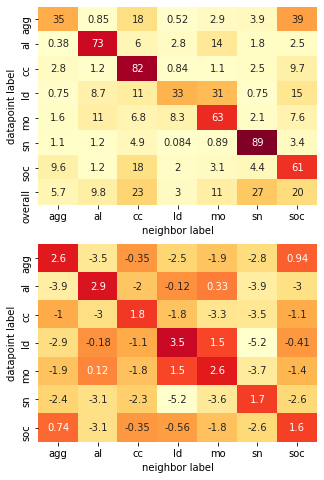

/content/drive/My Drive/meerkat/figures/features_original_space_eval.png


<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(5,8))

plt.subplot(2, 1, 1)
ax=sns.heatmap(stats_tab, annot=True, cmap='YlOrRd', cbar=None)
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
#plt.show()

plt.subplot(2, 1, 2)
ax=sns.heatmap(stats_tab_norm, center=0, annot=True, cmap='YlOrRd', cbar=None)
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
#plt.show()

#plt.savefig(FIGURES+'2020-10-14_embedding_denoised_melspectro_balanced_eval3D.png')
plt.savefig(FIGURES+'features_original_space_eval.png')

print(FIGURES+'features_original_space_eval.png')

## Spectrograms

In [ ]:
clean_indices = features.loc[features['SNR']>10,:].CALL_INDEX

spec_df = df[df['index_id'].isin(list(clean_indices))]
labels = spec_df.call_lable

specs = spec_df.denoised_spectrograms.values # now 2D arrays n_mels+time_frames(varying)

def pad_spectro(spec,maxlen):
  padding = maxlen - spec.shape[1]
  z = np.zeros((spec.shape[0],padding))
  padded_spec=np.append(spec, z, axis=1)
  return padded_spec

maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
specs_arr = np.asarray(flattened_specs)
data = specs_arr

In [ ]:
k=5

labels = np.asarray(labels)
calltypes = sorted(list(set(labels)))
indices, distances = get_knn(k,data)
nn_stats_dict = make_nn_stats_dict(calltypes, labels, indices)
stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels)

In [ ]:
print("Log final metric (unweighted):",np.mean(np.diagonal(stats_tab_norm)))
#print("Log Final metric (weighted):",round(np.average(np.diagonal(stats_tab_norm), weights=overall),2))
print("Log final metric (unweighted) gmean:",gmean(np.diagonal(stats_tab_norm)))
#print("Log Final metric (weighted):",round(gmean(np.diagonal(stats_tab_norm), weights=overall),2))
print("Abs final metric (unweighted):",round(np.mean(np.diagonal(stats_tab.iloc[:-1,])),2))
#print("Abs Final metric (weighted):",round(np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall),2))

Log final metric (unweighted): 2.3956997732200143
Log final metric (unweighted) gmean: 2.3230930056427477
Abs final metric (unweighted): 64.37


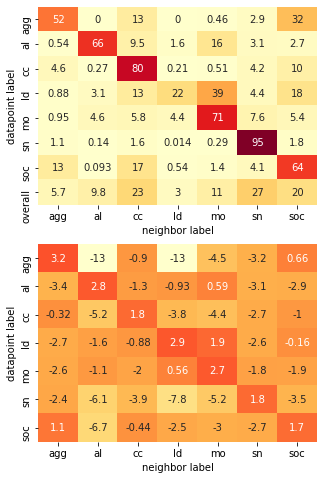

/content/drive/My Drive/meerkat/figures/spectro_original_space_eval.png


<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(5,8))

plt.subplot(2, 1, 1)
ax=sns.heatmap(stats_tab, annot=True, cmap='YlOrRd', cbar=None)
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
#plt.show()

plt.subplot(2, 1, 2)
ax=sns.heatmap(stats_tab_norm, center=0, annot=True, cmap='YlOrRd', cbar=None)
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
#plt.show()

#plt.savefig(FIGURES+'2020-10-14_embedding_denoised_melspectro_balanced_eval3D.png')
plt.savefig(FIGURES+'spectro_original_space_eval.png')

print(FIGURES+'spectro_original_space_eval.png')

## k-Curve

In [ ]:
metrics_dict = {}

Choose one of..

In [ ]:
encoding = 'spectrogram'
method = 'UMAP'

embedding = embedding_dict['UMAP']
labels = spec_df.call_lable

In [ ]:
# OR:
encoding = 'spectrogram'
method = 'original'

clean_indices = features.loc[features['SNR']>10,:].CALL_INDEX

spec_df = df[df['index_id'].isin(list(clean_indices))]
labels = spec_df.call_lable

specs = spec_df.denoised_spectrograms.values # now 2D arrays n_mels+time_frames(varying)

def pad_spectro(spec,maxlen):
  padding = maxlen - spec.shape[1]
  z = np.zeros((spec.shape[0],padding))
  padded_spec=np.append(spec, z, axis=1)
  return padded_spec

maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
#flattened_specs = [pad_spectro(spec, maxlen).flatten(order='A') for spec in specs]
specs_arr = np.asarray(flattened_specs)
data = specs_arr

# Normalize
#data = StandardScaler().fit_transform(pd.DataFrame(data))
embedding = np.asarray(data)

In [ ]:
# OR:
encoding = 'traditional'
method = 'UMAP'

embedding = embedding_dict['UMAP-trad']
labels = features.loc[features.SNR>10,]['Call_Type']

In [ ]:
# OR:
encoding = 'traditional'
method = 'original'

data = features.loc[features.SNR>10,]
labels = data.Call_Type
data = data.drop(columns=columns_to_drop)
data_z = StandardScaler().fit_transform(data)
embedding = np.asarray(data_z)

Calculate k's

In [ ]:
ks = [1,3,5,8,10,15,20,30,40]

metrics_tab = np.zeros((len(ks),4))
for k_num,k in enumerate(ks):
#k=1

  # Find k nearest neighbors
  nbrs = NearestNeighbors(metric='euclidean',n_neighbors=k+1, algorithm='brute').fit(embedding)
  distances, indices = nbrs.kneighbors(embedding)

  # need to remove the first neighbor, because that is the datapoint itself
  indices = indices[:,1:]  
  distances = distances[:,1:]

  nn_stats_dict = {}
  calltypes = sorted(list(set(labels)))
  labels = np.asarray(labels)

  for calltype in calltypes:
    call_indices = np.asarray(np.where(labels==calltype))[0]
    calltype_counts = np.zeros((call_indices.shape[0],len(calltypes)))

    for i,ind in enumerate(call_indices):
      nearest_neighbors = indices[ind]
      for neighbor in nearest_neighbors:
        neighbor_label = labels[neighbor]
        calltype_counts[i,np.where(np.asarray(calltypes)==neighbor_label)[0][0]] += 1 
    nn_stats_dict[calltype] = calltype_counts

  # Overall frequencies
  overall = np.zeros((len(calltypes)))
  for i,calltype in enumerate(calltypes):
    sub_emb = embedding[labels==calltype,:]
    overall[i] = sub_emb.shape[0] 

  overall = (overall/np.sum(overall))*100

  stats_tab = np.zeros((len(calltypes),len(calltypes)))
  stats_tab_norm = np.zeros((len(calltypes),len(calltypes)))

  for i, calltype in enumerate(calltypes):
    stats = nn_stats_dict[calltype]
    stats_tab[i,:] = (np.mean(stats,axis=0)/k)*100
    stats_tab_norm[i,:] = ((np.mean(stats,axis=0)/k)*100)/overall

  stats_tab = pd.DataFrame(stats_tab)
  stats_tab_norm = pd.DataFrame(stats_tab_norm)

  stats_tab.loc[len(stats_tab)] = overall
  #stats_tab_norm.loc[len(stats_tab_norm)] = overall/overall

  stats_tab.columns = calltypes
  stats_tab.index = calltypes+['overall']

  stats_tab_norm.columns = calltypes
  stats_tab_norm.index = calltypes
  x=stats_tab_norm.replace(0, 0.0001)
  stats_tab_norm = np.log2(x)

  metrics_tab[k_num,0] = np.mean(np.diagonal(stats_tab_norm))
  metrics_tab[k_num,1] = np.average(np.diagonal(stats_tab_norm), weights=overall)
  metrics_tab[k_num,2] = np.mean(np.diagonal(stats_tab.iloc[:-1,]))
  metrics_tab[k_num,3] = np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall)

metrics_dict[encoding+'_'+method] = metrics_tab

In [ ]:
metrics_dict.keys()

dict_keys(['spectrogram_UMAP', 'spectrogram_original', 'traditional_UMAP', 'traditional_original'])

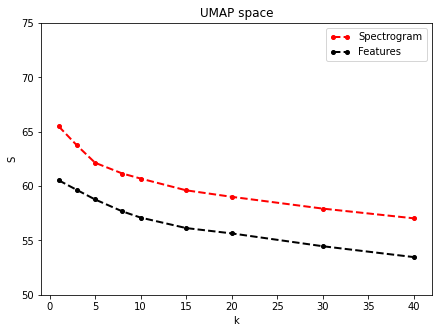

In [ ]:
fig = plt.figure(figsize= (7, 5))
plt.plot(ks, metrics_dict['spectrogram_UMAP'][:,2], color='red', marker='o', linestyle='dashed',linewidth=2, markersize=4, label="Spectrogram")
plt.plot(ks, metrics_dict['traditional_UMAP'][:,2], color='black', marker='o', linestyle='dashed',linewidth=2, markersize=4, label="Features")
plt.ylabel("S")
plt.xlabel("k")
plt.ylim(50,75)
plt.title("UMAP space")
plt.legend(numpoints=2)
plt.savefig(FIGURES+'embedded_space_ks.png')

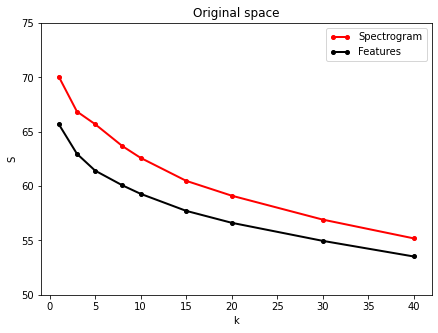

In [ ]:
fig = plt.figure(figsize= (7, 5))
plt.plot(ks, metrics_dict['spectrogram_original'][:,2], color='red', marker='o',linewidth=2, markersize=4, label="Spectrogram")
plt.plot(ks, metrics_dict['traditional_original'][:,2], color='black', marker='o', linewidth=2, markersize=4, label="Features")
plt.ylabel("S")
plt.xlabel("k")
plt.legend(numpoints=2)
plt.ylim(50,75)
plt.title("Original space")
plt.savefig(FIGURES+'original_space_ks.png')

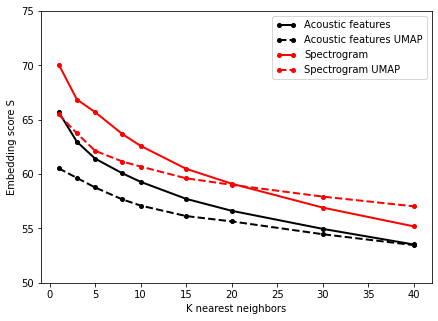

In [ ]:
fig = plt.figure(figsize= (7, 5))
plt.plot(ks, metrics_dict['traditional_original'][:,2], color='black', marker='o', linewidth=2, markersize=4, label="Acoustic features")
plt.plot(ks, metrics_dict['traditional_UMAP'][:,2], color='black', marker='o', linestyle='dashed',linewidth=2, markersize=4, label="Acoustic features UMAP")

plt.plot(ks, metrics_dict['spectrogram_original'][:,2], color='red', marker='o', linewidth=2, markersize=4, label="Spectrogram")
plt.plot(ks, metrics_dict['spectrogram_UMAP'][:,2], color='red', marker='o', linestyle='dashed',linewidth=2, markersize=4, label="Spectrogram UMAP")
plt.legend(numpoints=2)
plt.ylabel("Embedding score S")
plt.xlabel("K nearest neighbors")
plt.ylim(50,75)
plt.savefig(FIGURES+'all_ks.png')

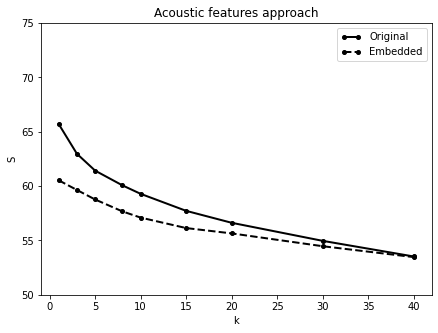

In [ ]:
fig = plt.figure(figsize= (7, 5))
plt.plot(ks, metrics_dict['traditional_original'][:,2], color='black', marker='o', linewidth=2, markersize=4, label="Original")
plt.plot(ks, metrics_dict['traditional_UMAP'][:,2], color='black', marker='o', linestyle='dashed',linewidth=2, markersize=4, label="Embedded")
plt.ylabel("S")
plt.xlabel("k")
plt.legend(numpoints=2)
plt.ylim(50,75)
plt.title('Acoustic features approach')
plt.savefig(FIGURES+'features_ks.png')

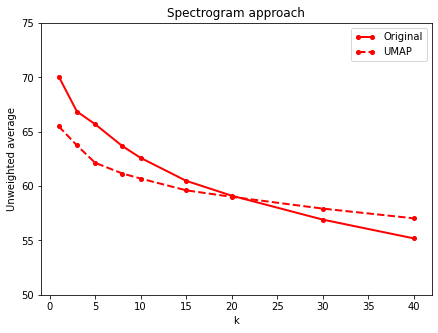

In [ ]:
fig = plt.figure(figsize= (7, 5))
plt.plot(ks, metrics_dict['spectrogram_original'][:,2], color='red', marker='o', linewidth=2, markersize=4, label="Original")
plt.plot(ks, metrics_dict['spectrogram_UMAP'][:,2], color='red', marker='o', linestyle='dashed',linewidth=2, markersize=4, label="UMAP")
plt.ylabel("Unweighted average")
plt.xlabel("k")
plt.legend(numpoints=2)
plt.ylim(50,75)
plt.title('Spectrogram approach')
plt.savefig(FIGURES+'spectrogram_ks.png')

# Save df

In [ ]:
features_red = features.loc[features.SNR>10,]
features_red

CALL_INDEX Call_Type  Energy_Duration  ...      F0_end        SNR        temp
1          10000        al         0.099750  ...  621.961806  39.723752    0.434028
2          10001        al         0.083625  ...  603.732639  37.009269  -75.954861
3          10002        al         0.082250  ...  578.993056  35.593729 -165.147569
4          10003        al         0.082500  ...  563.802083  25.857987  -49.913194
5          10004        al         0.080500  ...  501.953125  15.716379 -234.375000
...          ...       ...              ...  ...         ...        ...         ...
6663        9997        al         0.150250  ...  556.423611  37.416774   76.388889
6664        9998        al         0.117625  ...  607.204861  38.447165  131.944444
6665        9999        al         0.120000  ...  701.171875  46.632827  150.824653
6666          99        al         0.073625  ...  550.781250  33.567414  -39.930556
6667           9        sn         0.041625  ...  724.609375  23.959692   13.671875

[5306 rows x 18 columns]

In [ ]:
df.head(3)

index   Name        Start  ... certain_yn index_id nonfocal_yn
0   1598  ALARM  1:10:56.215  ...          y     1598           n
1   1599  ALARM  1:12:04.643  ...          y     1599           n
2   1600  ALARM  1:12:15.132  ...          y     1600           n

[3 rows x 36 columns]

In [ ]:
merged_df = features_red.merge(df, how='inner', right_on=["index_id"], left_on=["CALL_INDEX"])

In [ ]:
merged_df.head(10)

CALL_INDEX Call_Type  Energy_Duration  ...  certain_yn  index_id  nonfocal_yn
0       10000        al         0.099750  ...           y     10000            n
1       10001        al         0.083625  ...           y     10001            n
2       10002        al         0.082250  ...           y     10002            n
3       10003        al         0.082500  ...           y     10003            n
4       10004        al         0.080500  ...           y     10004            n
5       10008       soc         0.321000  ...           y     10008            n
6       10009       soc         0.307000  ...           y     10009            n
7       10010       soc         0.330625  ...           y     10010            n
8       10011       soc         0.336000  ...           y     10011            n
9       10012       soc         0.131750  ...           y     10012            n

[10 rows x 54 columns]

In [ ]:
meerkat_info = pd.read_csv(PROJECT_PATH+'Meerkat_info.csv', sep=";")

In [ ]:
import re
meerkat_names = meerkat_info['Code']

labelsep = re.compile('[\+\s]') # Match ? * ! %
meerkat_dyemarks = [labelsep.sub('', i) for i in list(meerkat_info['Dye mark'])]
meerkat_info['Dye mark'] = meerkat_dyemarks


meerkat_dict = meerkat_info.drop(columns=['Code', 'Name']).T
meerkat_dict.columns = meerkat_names
meerkat_dict = meerkat_dict.to_dict()

In [ ]:
for ind in sorted(list(set(merged_df['indv']))):
  if (not ind in meerkat_dict.keys()):
    if ind in meerkat_dyemarks:
      ind_row = meerkat_info[meerkat_info['Dye mark']== ind]
      ind_code = meerkat_info[meerkat_info['Dye mark'] == ind].Code.values[0]
      if(ind_code in meerkat_dict.keys()):
        meerkat_dict[ind] = meerkat_dict[ind_code]
        print(ind, "is actually ", ind_code)
    else:
      print(ind, "not in dyemarks")

HMB is actually  VCVM001
HRT not in dyemarks
HTB is actually  VHMF001
LT is actually  VHMF031
PET not in dyemarks
RT is actually  VHMF030
VHMM002 not in dyemarks
VHMM003 not in dyemarks
VLF206 not in dyemarks


In [ ]:
meerkat_dict['PET'] = meerkat_dict['VCVM001']
meerkat_dict['VHMM002'] = {'DOB': '27.10.16', 
                          'Dye mark': 'HRT', 
                          'Sex': 'M', 
                          'Status': 'Dominant'
                          }

meerkat_dict['VHMM003'] = {'DOB': '27.10.16', 
                          'Dye mark': 'HLT', 
                          'Sex': 'M', 
                          'Status': 'Adult'
                          }

meerkat_dict['VLF206'] = {'DOB': '21.08.2013', 
                          'Dye mark': 'RCRSTBL', 
                          'Sex': 'F', 
                          'Status': 'Adult'
                          }  
for ind in sorted(list(set(merged_df['indv']))):
  if (not ind in meerkat_dict.keys()):
    meerkat_dict[ind] = {'DOB': 'NA', 
                         'Dye mark': 'NA', 
                         'Sex': 'NA', 
                         'Status':'NA'}                         

In [ ]:
sex = [meerkat_dict[ind]['Sex'] for ind in merged_df['indv']]
merged_df['Sex'] = sex

In [ ]:
status = [meerkat_dict[ind]['Status'] for ind in merged_df['indv']]
merged_df['status'] = status

In [ ]:
merged_df.columns

Index(['CALL_INDEX', 'Call_Type', 'Energy_Duration', 'Spectral_Entropy',
       'Temporal_Entropy', 'Cepstral_Peak_Prominence', 'Centroid_Frequency',
       'Peak_Frequency', 'lower_frequency_10dB', 'Upper_Frequency_10dB',
       'Bandwidth_RMS', 'Bandwidth_10dB', 'F0_mean', 'F0_start', 'F0_mid',
       'F0_end', 'SNR', 'temp', 'index', 'Name', 'Start', 'Duration',
       'Time Format', 'Type', 'Description', 'call_yn', 'start_s',
       'duration_s', 'stop_s', 'date', 'samplerate_hz', 'indv', 'original_wav',
       'bout_number', 'call_lable', 'raw_audio', 'spectrograms', 'mfccs',
       'mfcc_deltas', 'mfcc_deltadeltas', 'soundfoc_yn',
       'stretched_spectrograms', 'stretched_mfccs', 'stretched_mfcc_deltas',
       'stretched_mfcc_deltadeltas', 'denoised_spectrograms',
       'denoised_stretched_spectrograms', 'denoised_mfccs',
       'denoised_stretched_mfccs', 'denoised_mfcc_deltas',
       'denoised_stretched_mfcc_deltas', 'certain_yn', 'index_id',
       'nonfocal_yn', 'Sex', 

In [ ]:
merged_df = merged_df[['index_id', 'call_lable', 'indv', 'Sex', 'status','soundfoc_yn', 'duration_s', 'SNR', 'date',
                       'Energy_Duration', 'Spectral_Entropy','Temporal_Entropy', 'Cepstral_Peak_Prominence', 'Centroid_Frequency',
                       'Peak_Frequency', 'lower_frequency_10dB', 'Upper_Frequency_10dB','Bandwidth_RMS', 'Bandwidth_10dB', 'F0_mean', 
                       'F0_start', 'F0_mid','F0_end',]]

In [ ]:
merged_df['F0_diff'] = merged_df['F0_end'] - merged_df['F0_start']

In [ ]:
merged_df['UMAP1'] = embedding[:,0]
merged_df['UMAP2'] = embedding[:,1]
merged_df['UMAP3'] = embedding[:,2]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [ ]:
merged_df

index_id call_lable     indv  ...      F0_mid      F0_end     F0_diff
0        10000         al  VHMM017  ...  546.006944  621.961806    0.434028
1        10001         al  VHMM017  ...  572.265625  603.732639  -75.954861
2        10002         al  VHMM017  ...  632.378472  578.993056 -165.147569
3        10003         al  VHMM017  ...  535.590278  563.802083  -49.913194
4        10004         al  VHMM017  ...  608.072917  501.953125 -234.375000
...        ...        ...      ...  ...         ...         ...         ...
5301      9997         al  VHMM017  ...  528.211806  556.423611   76.388889
5302      9998         al  VHMM017  ...  549.479167  607.204861  131.944444
5303      9999         al  VHMM017  ...  626.736111  701.171875  150.824653
5304        99         al       RT  ...  529.296875  550.781250  -39.930556
5305         9         sn       RT  ...  718.750000  724.609375   13.671875

[5306 rows x 24 columns]

In [ ]:
merged_df.to_pickle(DATA+'trad_df_extra')

In [ ]:
merged_df.to_csv(DATA+'trad_df_extra.csv', index=False) 

In [ ]:
[type(c) for c in merged_df.columns]

[str,
 str,
 str,
 str,
 str,
 str,
 str,
 str,
 str,
 str,
 str,
 str,
 str,
 str,
 str,
 str,
 str,
 str,
 str,
 str,
 str,
 str,
 str,
 str]

In [ ]:
check = pd.read_pickle(DATA+'trad_df')

In [ ]:
check

index_id call_lable     indv  ...      UMAP1      UMAP2     UMAP3
0        10000         al  VHMM017  ...   8.317818  11.001134  2.826596
1        10001         al  VHMM017  ...  12.192611   9.671962  5.030622
2        10002         al  VHMM017  ...  10.455763   8.839529  6.625865
3        10003         al  VHMM017  ...  11.664174   9.458163  5.245267
4        10004         al  VHMM017  ...  11.447092   9.371478  5.409429
...        ...        ...      ...  ...        ...        ...       ...
5301      9997         al  VHMM017  ...  11.354084  10.780102  1.734913
5302      9998         al  VHMM017  ...  11.318239  10.821651  1.655315
5303      9999         al  VHMM017  ...   8.294176  11.032449  2.767647
5304        99         al       RT  ...  12.172396   9.591087  5.110449
5305         9         sn       RT  ...  11.560659   9.568269  5.006294

[5306 rows x 12 columns]

# Search representative calls

In [ ]:
df.shape

(6687, 36)

In [ ]:
calltypes = sorted(list(set(df.call_lable.values)))

In [ ]:
# from meerkat_preprocessing

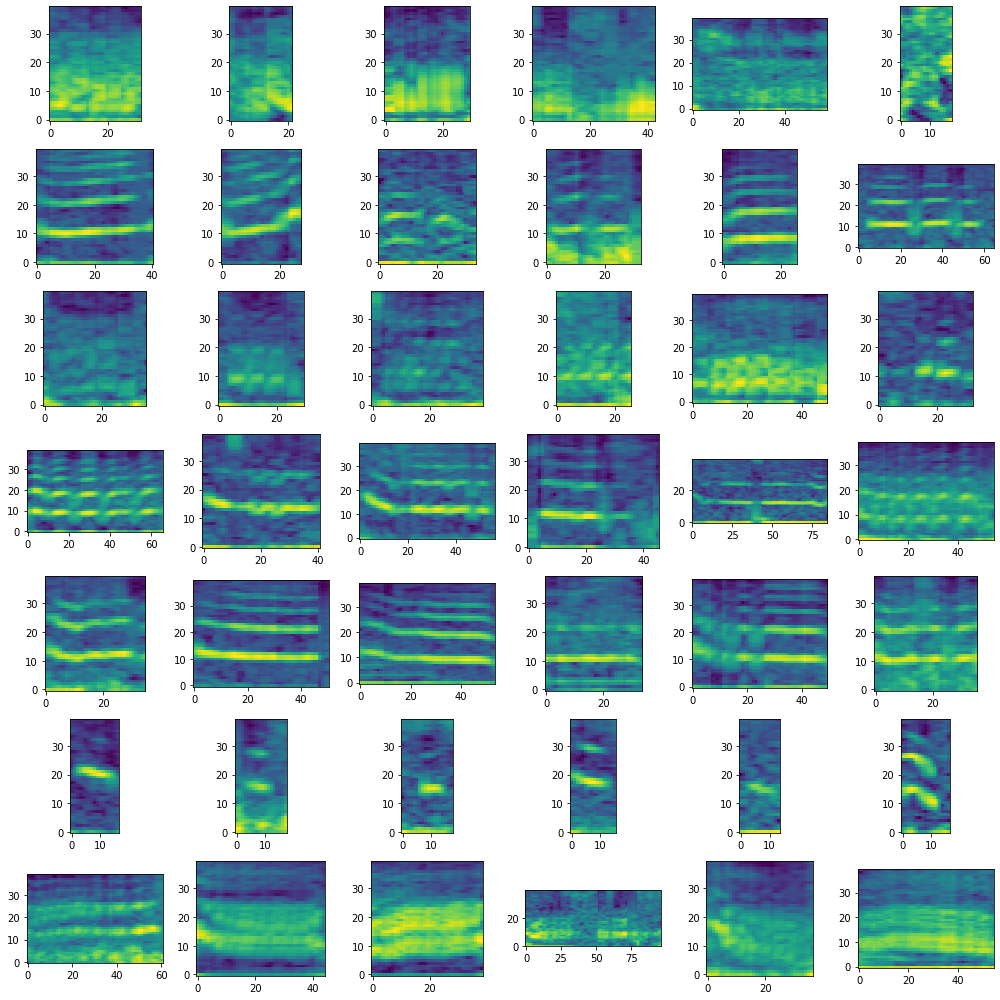

In [ ]:
specs=df.denoised_spectrograms.values
maxlen= np.max([spec.shape[1] for spec in specs])

fig = plt.figure(figsize=(14,14))
k=1
for i,calltype in enumerate(calltypes):
  df_sub = df[df['call_lable']==calltype]
  example = df_sub.sample(n=6, random_state=2204)
  specs=example.denoised_spectrograms.values
  #specs=example.spectrograms.values
  labelnames = example.Name.values
  for j,spec in enumerate(specs):
      plt.subplot(7, 6, k)
      plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal') 
      title = labelnames[j]
      #plt.title(title)
      k+=1
plt.tight_layout() 
#plt.show()
plt.savefig(FIGURES+'examples_of_all_2_no_title.jpg')

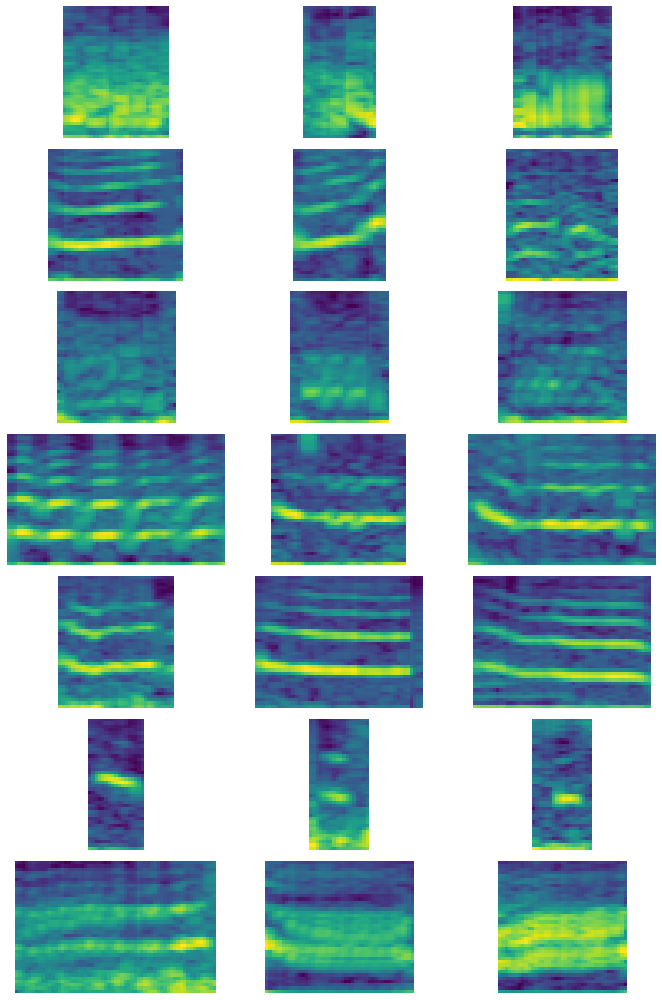

In [ ]:
df_sub = df[df['call_lable']==calltype]
example = df_sub.sample(n=6)
specs=example.denoised_spectrograms.values
maxlen= np.max([spec.shape[1] for spec in specs])

fig = plt.figure(figsize=(10,14))
k=1
for i,calltype in enumerate(calltypes):
  df_sub = df[df['call_lable']==calltype]
  example = df_sub.sample(n=3, random_state=2204)
  specs=example.denoised_spectrograms.values
  labelnames = example.call_lable.values
  for j,spec in enumerate(specs):
      plt.subplot(7, 3, k)
      plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal') 
      plt.axis('off')
      title = labelnames[j]
      #plt.title(title)
      k+=1
plt.tight_layout() 
#plt.show()
plt.savefig(FIGURES+'n3_examples.jpg')

# Find misclassified calls

Given distances, indices and the embedding

In [ ]:
distances, indices = nbrs.kneighbors(embedding)

In [ ]:
labels = features.loc[features.SNR>10,]['Call_Type'].tolist()
index_ids = features.loc[features.SNR>10,]['CALL_INDEX'].tolist()

In [ ]:
#give an index, return a label
index_label_dict = dict(zip(np.arange(0,data.shape[0],1).tolist(), labels))

#give an index, return the index_id
index_index_dict = dict(zip(np.arange(0,data.shape[0],1).tolist(), index_ids))

In [ ]:
wrong_neighbors = []
wrong_neighbors_ids = []
wrong_datapoint = []
wrong_index = []

for i in range(data.shape[0]):
  datapoint_label = labels[i]
  neighbors = indices[i]
  neighbor_labels = [index_label_dict[x] for x in neighbors]
  neighbor_ids = [index_index_dict[x] for x in neighbors]
  if datapoint_label not in neighbor_labels:
    wrong_neighbors.append(neighbor_labels)
    wrong_neighbors_ids.append(neighbor_ids)
    wrong_datapoint.append(datapoint_label)
    wrong_index.append(index_ids[i])

In [ ]:
len(wrong_datapoint)

512

In [ ]:
wrong_df = pd.DataFrame(list(zip(wrong_index, wrong_datapoint)), 
               columns =['CALL_INDEX', 'Call_Type']) 

In [ ]:
wrong_neighbors_arr = np.vstack(wrong_neighbors)

for i in range(wrong_neighbors_arr.shape[1]):
  col_name = "neighbor_"+str(i+1)
  wrong_df[col_name] = wrong_neighbors_arr[:,i]

In [ ]:
wrong_neighbors_ids_arr = np.vstack(wrong_neighbors_ids)

for i in range(wrong_neighbors_ids_arr.shape[1]):
  col_name = "neighbor_"+str(i+1)+"_id"
  wrong_df[col_name] = wrong_neighbors_ids_arr[:,i]

In [ ]:
wrong_df

CALL_INDEX Call_Type  ... neighbor_4_id neighbor_5_id
0         10001        al  ...         22181         13177
1         10003        al  ...         15457         20148
2         10004        al  ...          3299           743
3         10018        al  ...            20         24582
4         10034       agg  ...          3286          4509
..          ...       ...  ...           ...           ...
507        9941       agg  ...         14847         19630
508        9942       agg  ...         18685          8217
509        9944       agg  ...         18511          2231
510        9947       agg  ...         21602          9509
511          99        al  ...         13177         13185

[512 rows x 12 columns]

In [ ]:
wrong_df.to_csv(DATA+'frants/wrong_classi_calls.csv', index=False)

# Compare with Silhouette

In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm

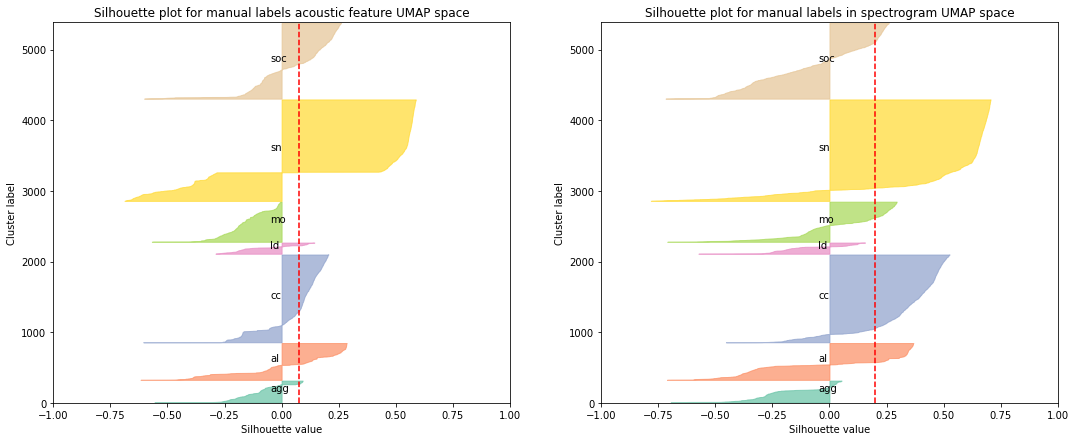

In [23]:
embedding = embedding_dict['UMAP']
labels = labels = spec_df.call_lable

labeltypes = sorted(list(set(labels)))
n_clusters = len(labeltypes)

# Create a subplot with 1 row and 2 columns
#fig, ax1 = plt.figure(figsize= (10, 10))
fig, (ax2, ax1) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

ax1.set_xlim([-1, 1])

ax1.set_ylim([0, embedding.shape[0] + (n_clusters + 1) * 10])

#cluster_labels = umap_df['HDBSCAN']
cluster_labels = labels
silhouette_avg = silhouette_score(embedding, cluster_labels)


# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(embedding, cluster_labels)
y_lower = 10

pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))


for i, cluster_label in enumerate(labeltypes):
  ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == cluster_label]

  ith_cluster_silhouette_values.sort()

  size_cluster_i = ith_cluster_silhouette_values.shape[0]
  y_upper = y_lower + size_cluster_i


  ax1.fill_betweenx(np.arange(y_lower, y_upper),
                    0, ith_cluster_silhouette_values,
                    facecolor=color_dict[cluster_label], edgecolor=color_dict[cluster_label], alpha=0.7)
  ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, cluster_label)

    # Compute the new y_lower for next plot
  y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("Silhouette plot for manual labels in spectrogram UMAP space")
ax1.set_xlabel("Silhouette value")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")


##### ****************************************************

embedding = embedding_dict['UMAP-trad']
labels = features.loc[features.SNR>10,]['Call_Type']

labeltypes = sorted(list(set(labels)))
n_clusters = len(labeltypes)

ax2.set_xlim([-1, 1])

ax2.set_ylim([0, embedding.shape[0] + (n_clusters + 1) * 10])
#cluster_labels = umap_df['HDBSCAN']
cluster_labels = labels
silhouette_avg = silhouette_score(embedding, cluster_labels)


# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(embedding, cluster_labels)
y_lower = 10

pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))


for i, cluster_label in enumerate(labeltypes):
  ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == cluster_label]

  ith_cluster_silhouette_values.sort()

  size_cluster_i = ith_cluster_silhouette_values.shape[0]
  y_upper = y_lower + size_cluster_i


  ax2.fill_betweenx(np.arange(y_lower, y_upper),
                    0, ith_cluster_silhouette_values,
                    facecolor=color_dict[cluster_label], edgecolor=color_dict[cluster_label], alpha=0.7)
  ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, cluster_label)

    # Compute the new y_lower for next plot
  y_lower = y_upper + 10  # 10 for the 0 samples

ax2.set_title("Silhouette plot for manual labels acoustic feature UMAP space")
ax2.set_xlabel("Silhouette value")
ax2.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax2.axvline(x=silhouette_avg, color="red", linestyle="--")


#plt.show()
plt.savefig(FIGURES+'traditional_vs_spectrogram_SIL.png')

In [26]:
embedding = embedding_dict['UMAP-trad']
labels = features.loc[features.SNR>10,]['Call_Type']
print(silhouette_score(embedding, labels))

0.07563853


In [27]:
embedding = embedding_dict['UMAP']
labels = spec_df.call_lable.values
print(silhouette_score(embedding, labels))

0.19745976


In [28]:
labeltypes = sorted(list(set(labels)))
n_clusters = len(labeltypes)

sil_trad ={}

#cluster_labels = umap_df['HDBSCAN']
embedding = embedding_dict['UMAP-trad']
cluster_labels = features.loc[features.SNR>10,]['Call_Type']

silhouette_avg = silhouette_score(embedding, cluster_labels)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(embedding, cluster_labels)


for i, cluster_label in enumerate(labeltypes):
  ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == cluster_label]
  sil_trad[cluster_label] = np.mean(ith_cluster_silhouette_values)

##### ****************************************************

sil_spectro = {}
#cluster_labels = umap_df['HDBSCAN']
embedding = embedding_dict['UMAP']
cluster_labels = spec_df.call_lable.values

silhouette_avg = silhouette_score(embedding, cluster_labels)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(embedding, cluster_labels)


for i, cluster_label in enumerate(labeltypes):
  ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == cluster_label]

  sil_spectro[cluster_label] = np.mean(ith_cluster_silhouette_values)

In [30]:
np.mean(np.asarray([sil_trad[x] for x in labeltypes]))

0.011719614

In [31]:
np.mean(np.asarray([sil_spectro[x] for x in labeltypes]))

0.082748376